In [1]:
import spot
import buddy
from utils import timer
spot.setup()

In [2]:
import javaobj
from dfs.dfs_node import DFSNode

def transform_dict(d, per_bthread):
    visited = {}
    nodes_map = {}
    total_events = set()
    counter = 0
    for s in d:
        try:
            n = DFSNode(tuple(), str(s))
        except Exception:
            print(s)
            continue
        must_finish_str = str(d[s]["H"]).split(",")
        must_finish_dict = dict([(must_finish_str[2*i], must_finish_str[2*i+1] == "1") for i in range(len(must_finish_str)//2)])
        n.must_finish = [must_finish_dict["box" + str(x)] for x in range(len(must_finish_dict))]
        visited[n] = counter
        nodes_map[str(s)] = n
        counter += 1
    for s in d:
        for e in d[s]:
            if e == "H":
                continue
            l = str(e)
            nodes_map[str(s)].transitions[l] = nodes_map[str(d[s][e])]
            if per_bthread:
                nodes_map[str(s)].rewards[l] = sum([int(y)-int(x) for x,y in zip(nodes_map[str(d[s][e])].must_finish, nodes_map[str(s)].must_finish)])
            else:
                nodes_map[str(s)].rewards[l] = int(not any(nodes_map[str(d[s][e])].must_finish)) - \
                                               int(not any(nodes_map[str(s)].must_finish))
            total_events.add(l)
    s_to_change = [k for k, v in visited.items() if v == 0][0]
    init_s = [nodes_map[x] for x in nodes_map if x.startswith("I")][0]
    number_to_change = visited[init_s]
    visited[init_s] = 0
    visited[s_to_change] = number_to_change
    return init_s, visited, total_events, None


In [14]:
i = "map_6_8_3_test"
PER_BT = True
with open("examples/graph_objects/sokoban_cobp_" + str(i) + ".ser", "rb") as fd:
    jobj = fd.read()
    pobj = javaobj.loads(jobj)
    init, states_dict, events, liveness_bthreads = transform_dict(pobj, PER_BT)
states = list(states_dict)
bdict = spot.make_bdd_dict()
game = spot.make_twa_graph(bdict)
dict_bdd = {}
for e in events:
    dict_bdd[e] = buddy.bdd_ithvar(game.register_ap(e))
game.new_states(len(states_dict))
for s1, id1 in states_dict.items():
    for e, s2 in s1.transitions.items():
        l = [i for i in range(len(s2.must_finish)) if not s2.must_finish[i]]
        game.new_edge(id1, states_dict[s2], dict_bdd[e], l)
        #print(id1, states_dict[s2], l)

game.set_init_state(0)
game.set_generalized_buchi(len(s1.must_finish))
spot.set_state_players(game, [True] * len(states))

In [15]:
dict([(k.id,v) for k,v in states_dict.items()])

{'S_2_3_D_1_2_2_4': 5,
 'S_3_2_D_1_2_2_3': 1,
 'S_2_2_D_1_2_2_3': 2,
 'S_2_2_D_1_2_2_4': 3,
 'S_3_2_D_1_2_2_4': 4,
 'I_3_2_D_2_2_2_3': 0}

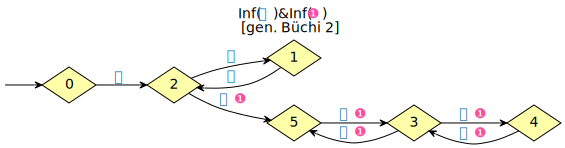

In [16]:
game.show('.g')

In [5]:
p_game = spot.parity_type_to_parity(game)
spot.set_state_players(p_game, [True] * len(states))
spot.solve_parity_game(p_game)

False

In [ ]:
spot.highlight_strategy(p_game)
p_game.show('.g')